In [1]:
import sys


In [2]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
def read_data():
    df=pd.read_csv('../input/newtrain_part2.csv',index_col=0)
    for col in df.columns:
        if df[col].dtype==np.float64:
            df[col]=df[col].astype(np.float32)
        elif df[col].dtype==np.int64:
            df[col]=df[col].astype(np.int32)
    return df

In [4]:
df=read_data()
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297606 entries, 929557 to 125694
Columns: 63 entries, ps_calc_01 to target
dtypes: float32(3), int32(60)
memory usage: 73.8 MB


In [7]:
import cPickle as pickle
unique_conds=pickle.load(open("xgb_conds.pkl"))

In [8]:
len(unique_conds)

40236

In [9]:
idx=pd.concat([pd.read_csv("lasso_feats_i100_r0.0005_e1_q.txt",header=None)],axis=0).values.astype(np.bool)[:,0]
idx.shape,idx.sum()

((40236,), 3263)

In [10]:
assert len(idx)==len(unique_conds)

In [11]:
unique_conds=[u for i,u in enumerate(unique_conds) if idx[i]]
len(unique_conds)

3263

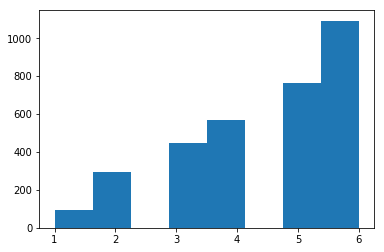

In [12]:
plt.hist([len(u) for u in unique_conds],bins=8);

In [13]:
def value_cond_tuple (df,cond):
    #print cond
    col=cond[1]
    if cond[0]=='missing':
        return np.isnan(df[col])
    else:
        split_val=cond[2]
        if cond[0]=='yes':
            return df[col]<split_val
        elif cond[0]=='no':
            return df[col]>=split_val
        else:
            raise "never be here"
def value_cond_single(df,conds):
    return reduce(lambda u,v: u | v, [value_cond_tuple(df,cond) for cond in conds])
def value_cond(df,conds):
    return reduce(lambda u,v: u & v, [value_cond_single(df,cond) for cond in conds])
def value_trees(df,trees):
    cond_lists=reduce(lambda u,v: u+v, [enumerate_all_conds(tree) for tree in trees])
    return cond_lists, pd.DataFrame([value_cond(df, conds) for conds in cond_lists]).T

In [14]:
value_cond(df,unique_conds[17]).mean()

0.13110622769702224

In [15]:
import os
memory="20g"
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

In [16]:
import findspark
findspark.init()

In [17]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf()
conf.set('spark.executor.cores',1)
conf.set('spark.executor.instances',1) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','40G') 
conf.set('spark.executor.memory','7G') 

#conf.set('spark.cores.max',15)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")
#conf.setMaster("local")

In [18]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext

In [19]:
len(unique_conds)

3263

In [20]:
df.shape[0]*8*len(unique_conds)/1024**3./3/19

0.12693284608815847

In [21]:
df.shape[0]*4*len(unique_conds)/1024**3./3/2/1000

0.0006029310189187527

In [22]:
conds=unique_conds

In [23]:
conds_bc=sc.broadcast(conds)

In [24]:
data_rdd=sc.parallelize(df.values,1000)

In [25]:
#data_rdd.mapPartitions(lambda u: [len(list(u))]).collect()

In [26]:
columns=[str(u) for u in df.columns]

In [27]:
def run_once(partition):
    #return str(type(partition))
    subdf=pd.DataFrame(list(partition),columns=columns)
    
    v=[value_cond(subdf,u) for u in conds_bc.value]
    v.append(subdf['target'])
    retdf=pd.concat(v,axis=1).astype(np.int32).astype(np.str)
    assert(retdf.shape[0]==subdf.shape[0])
    assert(retdf.shape[1]==len(conds_bc.value)+1)    
    return [",".join(u) for u in retdf.values]
    

In [28]:
filename="/tmp/p/cond_feat_3_5e4.txt"

In [29]:
!hadoop fs -rmr {filename}

rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/11 04:21:37 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/p/cond_feat_3_5e4.txt


In [30]:
data_rdd.mapPartitions(run_once).saveAsTextFile(filename)

In [31]:
sc.textFile(filename).getNumPartitions()

1000

In [32]:
sc.textFile(filename).map(lambda u: int(u.split(",")[-1])).mean()

0.03638367506031466

In [33]:
sc.stop()